# Generate figures for publication
Generate 3-4 figures for publication that summarizes the current progress of the project 

In [1]:
# changing cwd
%cd ..

c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp


## Load packages

In [2]:
from src.inductive_bias import IB
ib = IB() #instantiate inductive bias package

[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\SimulationData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\PosteriorData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\TrainedCLF.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\EstimatedData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\HellingerData.pickle ] loaded
Size of the S-XOR: (6322,)                    
Size of the Spiral: (6276,)                    
Size of the whole dataset: (12598, 7)

Size of the S-XOR after adding hellinger: (6322, 8)            
Size of the Spiral after adding hellinger: (6276, 8)


## Time and Date of the experiment

In [3]:
print(ib.date)

2021-08-25 04:36:37.230083


## Load Dependencies

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

from mpl_toolkits.axes_grid1 import AxesGrid

cmap = 'PRGn'

import warnings
warnings.filterwarnings('ignore')

import imageio

In [5]:
#generic global
uX = ib.mask #3600 points
uX0, uX1 = uX[:,0], uX[:,1]

# ib.mask = ib.generate_mask(rng=4.3) #739.6k points
label = ib.mtype[:3] + ['Human'] #excluding QDA
dtype = ib.dtype[2:5:2]
fsize = 18

#figure
SAVEFIG = True

In [6]:
label = ib.mtype[:3] + ['Human']

In [7]:
ib.load_sampledData()

[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\SampledData.pickle ] loaded


## Point-wise averaging and gaussian smoothing estimated posterior
As demonstrated previously, these operations allow for apple to apple comparison between ML and humans, after which the grid coordinates exactly match between ML and human

In [8]:
mtype = []
ib.mask = ib.generate_mask(h=0.1)

for ii in range(2): #S-XOR and spiral
    mtype.append([])
    
    for jj in range(4):
        if jj == 3:
            mtype_i = np.column_stack([ib.human[ii][:,3], ib.human[ii][:,5], ib.human[ii][:,0]]) # human estimates
        else:
            mtype_i = ib.estpst_sample[ii][jj] # ML estimates        
        
        mtype_i = ib.pointwise_gridAverage(mtype_i).to_numpy()        
        xy, original, down, alls = ib.smooth_gaussian_distance(mtype_i, step=0.01, method=None, sigma=1, k=10)
        mtype[ii].append(alls)

## Compute Hellinger Distance between ML and humans
The metric for comparison is a point-wise hellinger distance

In [9]:
hdists = []

for row in range(2):
    hdists.append([])
    for col in range(3):
        hdists[row].append(ib._hellinger_explicit(mtype[row][col], mtype[row][3]))

## Figure 1


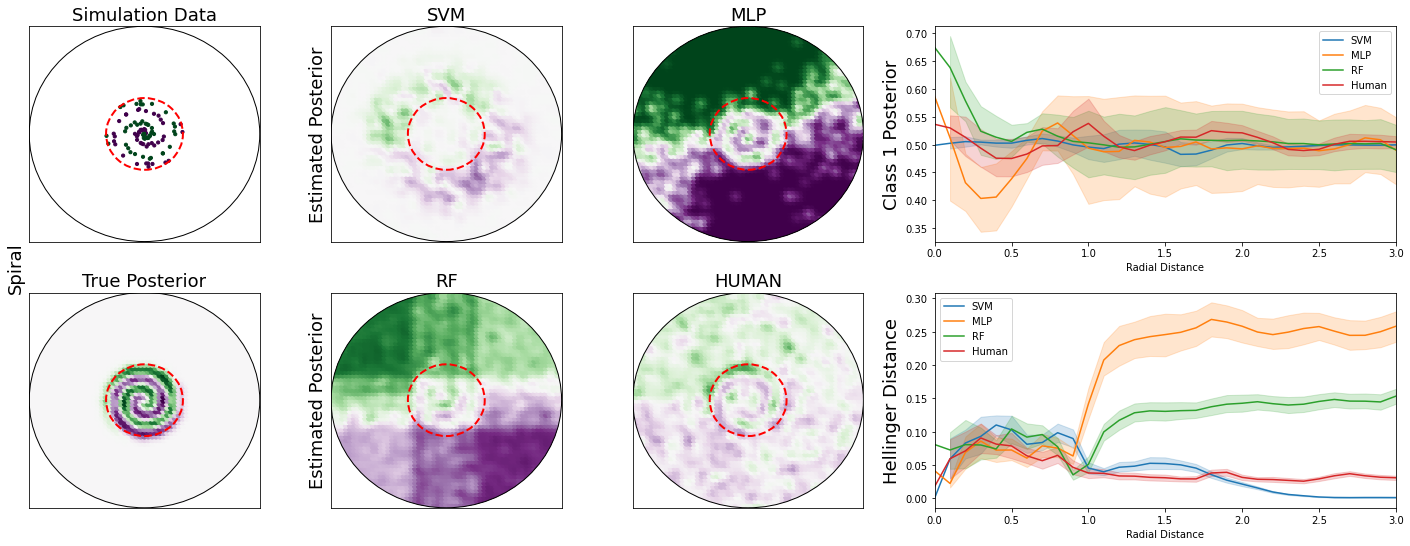

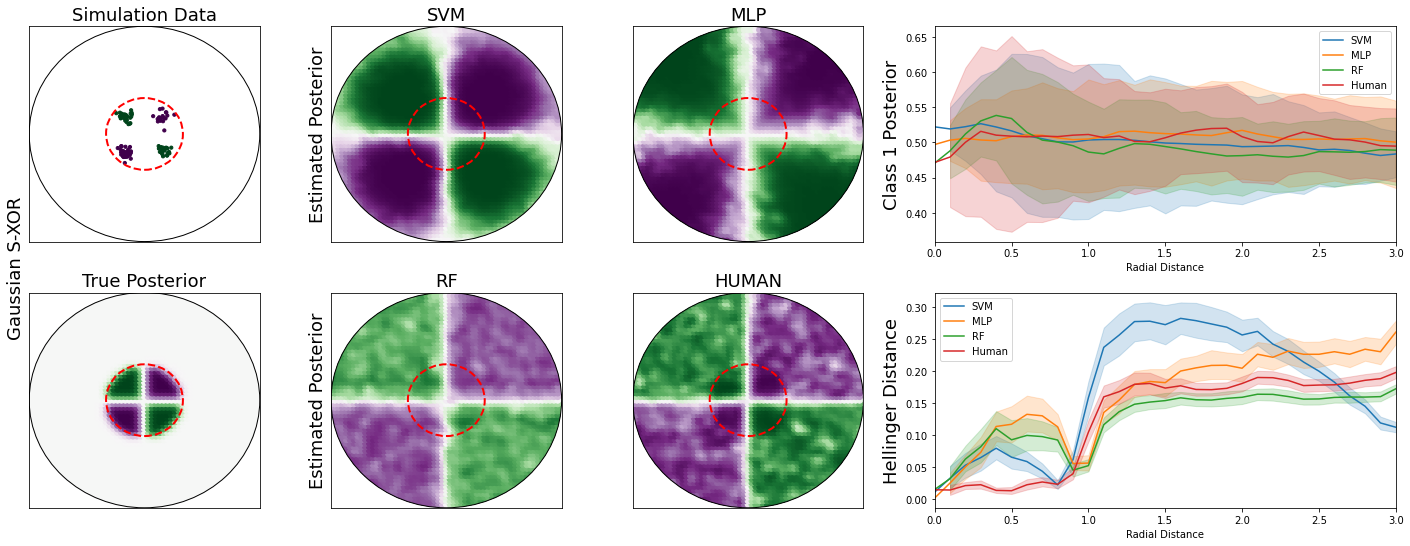

In [61]:
'''
This figure contains simulation data at idx[0,0], true posterior at idx[1,0], 
estimated posterior at idx[i=1,2|j=1,2], class 1 posterior at idx[0,3], and hellinger distance at idx[1,3]
'''
row = 2
col = 4
interp_method = 'linear'  # interpolation methods
fname = ['spiral', 'sxor']

for ii, j in enumerate([2,4]):#[2, 4]

    cnt = 0

    widths = [4, 4, 4, 8]
    fig = plt.figure(figsize=(4*(col+1), 4*row))
    spec = fig.add_gridspec(ncols=col, nrows=row, width_ratios=widths)

    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')

    ax.set_ylabel(ib.dtype[j], fontsize=18)

    for k in range(row):
        for i in range(col):
            cnt += 1

            axs = fig.add_subplot(spec[k, i])

            # simulation dataset
            if cnt == 1:
                pcm = axs.scatter(ib.train_X[j][:,0], ib.train_X[j][:,1], c=ib.train_y[j], cmap=cmap, s=10)

            # true posterior
            elif cnt == 5:                
                cc = ib.pointwise_gridAverage( np.array([ib.truepst[1][j]])[0].T ).to_numpy() #unit circle true posteriors
                xy_true, original, down, alls_true = ib.smooth_gaussian_distance(cc, step=0.01, method=None, sigma=1, k=10)

                pcm = axs.scatter(x=np.array(xy_true)[:,0], y=np.array(xy_true)[:,1], c=alls_true, cmap=cmap)

            elif cnt in [2,3,6,7]:
                # estimated posterior (SVM)
                if cnt == 2:
                    mtype_i = mtype[ii][0]
                    axs.set_title(ib.mtype[0], fontsize=fsize)
                # estimated posterior (MLP)
                elif cnt == 3:
                    mtype_i = mtype[ii][1]
                    axs.set_title(ib.mtype[1], fontsize=fsize)
                # estimated posterior (RF)
                elif cnt == 6:
                    mtype_i = mtype[ii][2]
                    axs.set_title(ib.mtype[2], fontsize=fsize)
                # human estimates
                elif cnt == 7:                     
                    mtype_i = mtype[ii][3]
                    axs.set_title('HUMAN', fontsize=fsize)

                pcm = axs.scatter(x=np.array(xy)[:,0], y=np.array(xy)[:,1], c=mtype_i, cmap=cmap, vmin=0, vmax=1)

            # radial line plot
            elif cnt in [4,8]:
                for i in range(4):
                    
                    if cnt == 4: # HUMAN class 1 posterior
                        temp = ib.get_radialDist(np.column_stack([xy, mtype[ii][i]]).astype(float))

                    elif cnt == 8: # HUMAN hellinger
                        htemp = ib._hellinger_explicit(mtype[ii][i], alls_true)
                        temp = ib.get_radialDist(np.column_stack([xy, htemp]).astype(float))
 
                    temp2 = pd.DataFrame(temp[1]).T
                    temp2.columns = temp[0]
                    temp2 = temp2.melt().dropna()
                    temp2.columns=['Radial Distance', ''] #x and y axis label
                    sns.lineplot(data=temp2, x=temp2.columns[0], y=temp2.columns[1], ci=95, label=label[i], ax=axs)
            
            ## figure styling ##
            if cnt != 4 and cnt != 8:                
                circle = Circle((0, 0), 3, linewidth=1, edgecolor='k', facecolor='none') # outer bounding circle                
                axs.add_patch(Circle((0, 0), radius=1, linewidth=2, ls='--', edgecolor='r', fill=False)) # inner unit circle                
                axs.add_patch(circle)
                pcm.set_clip_path(circle)

                axs.set_xlim([-3, 3])
                axs.set_ylim([-3, 3])

            if k == 0 and i == 0:
                axs.set_title('Simulation Data', fontsize=fsize)

            if k == 1 and i == 0:
                axs.set_title('True Posterior', fontsize=fsize)

            if k == 0 and i == 3:
                axs.set_ylabel('Class 1 Posterior', fontsize=fsize)
                axs.set_xlim([0, 3])

            if k == 1 and i == 3:
                axs.set_ylabel('Hellinger Distance', fontsize=fsize)
                axs.set_xlim([0, 3])

            if i == 1 and (k == 0 or k == 1):
                axs.set_ylabel('Estimated Posterior', fontsize=fsize)

            if i < 3:
                axs.set_xticks([])
                axs.set_yticks([])

    plt.tight_layout(pad=2)
    if SAVEFIG:
        plt.savefig(f'figs/[20210820_generate_pub_figures]_figure1_{fname[ii]}_{str(ib.date.date())}.jpg', bbox_inches='tight')

## Figure 2

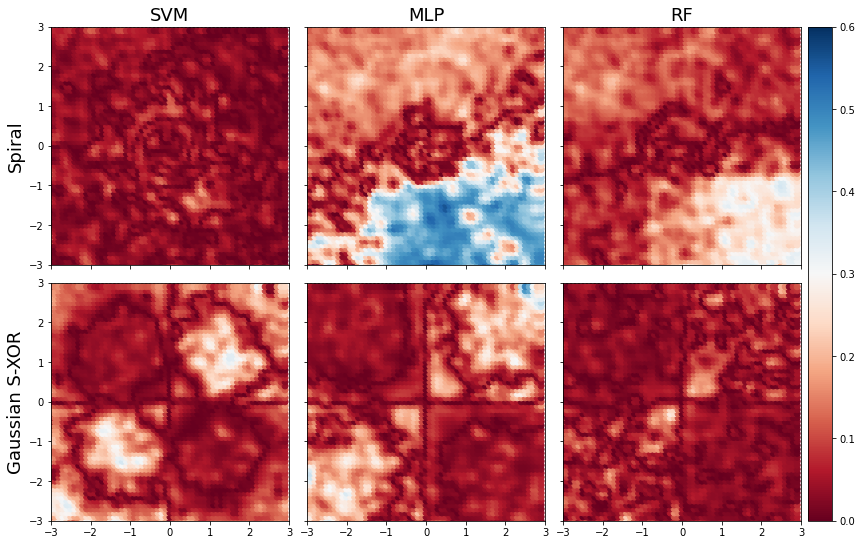

In [11]:
fig = plt.figure(figsize=(7*2, 7*3))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 3),
                axes_pad=0.25,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

idx = 0

for ax in grid:
    row = idx // 3
    col = idx % 3
    # ax.set_axis_off()        
    mlp = ax.scatter(ib.mask[:,0], ib.mask[:,1], c=hdists[row][col], cmap='RdBu', vmin=0, vmax=np.array(hdists).max().round(1))

    if row == 0:
        ax.set_title(ib.mtype[col], fontsize=fsize)

    if col == 0:
        ax.set_ylabel(dtype[row], fontsize=fsize)

    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])
    ax.set_yticks(np.arange(-3,4))
    ax.set_xticks(np.arange(-3,4))
    
    idx += 1    

cbar = ax.cax.colorbar(mlp)
cbar.ax.set_yticks(np.arange(0, 1.1, 0.5))

# fig.suptitle("Hellinger Distance against human prediction", y=0.72, fontsize=25)

if SAVEFIG:  
    plt.savefig(f'figs/[20210820_generate_pub_figures]_figure2_{str(ib.date.date())}.jpg', bbox_inches='tight')

plt.show()

## Figure 3

In [56]:
angle_step = 12 #default = 12
new_dtype = ['Original'] + dtype
fdtype = ['spiral', 'sxor'] #dtype defined for filename

palette = sns.color_palette('bright', len(ib.mtype))

col = 1
row = 1

step = 0.2
r = 4
x_range = np.arange(-r,r,step)
angles = np.arange(0, 180+angle_step, angle_step)
# angles = np.array([0,180]) #just to check to see if 0 and 180 yields the same results

line_plots = []
line_posts = []

for deg in tqdm(angles):

    line_plot = []
    line_post = []

    #selecting linear region of interest over hellinger distance at given degree of angle
    for i in tqdm(range(2), leave=False):    
        line_plot.append([])
        line_post.append([])

        for j in range(3):
            line_plot[i].append([])
            line_post[i].append(ib.select_linear_region(hdists[i][j], degree=deg, step=0.001))
            
            lp, li = line_post[i][j] #line posterior, line index
            x = ib.mask[li][:,0]
            y = ib.mask[li][:,1]
            dist = np.sqrt(x**2 + y**2)

            dist[y < 0] *= -1 # negative radial distance wrt y-coordinate

            for rad in x_range:              
                line_plot[i][j].append(np.array(lp[(dist >= rad) * (dist < rad+step)]).mean())

    line_plots.append(line_plot)
    line_posts.append(line_post)

100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


In [57]:
line_plots = np.array(line_plots)
line_plots.shape

(16, 2, 3, 40)

In [58]:
lp_temp = np.swapaxes(line_plots,0,1)
lp_temp[0,:,0].shape

(16, 40)

In [59]:
SAVEFIG = False

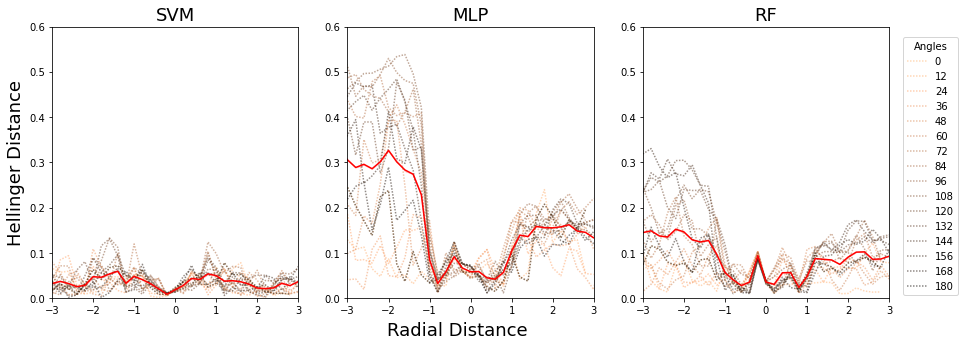

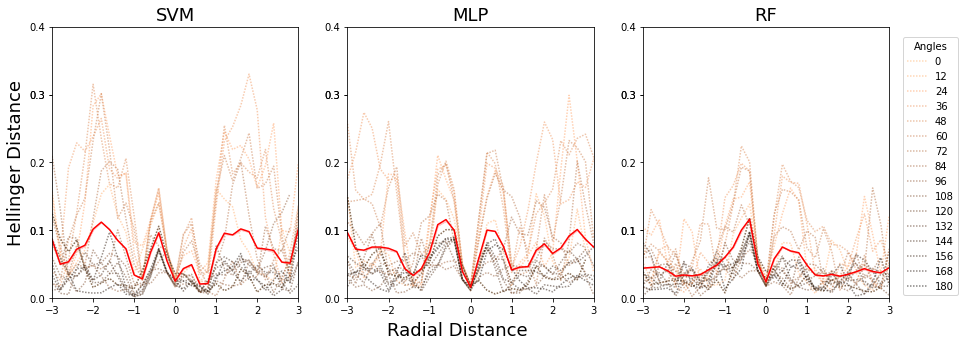

In [60]:
for j in range(2):
    
    fig, ax = plt.subplots(1,3, figsize=[5*3,5])    
    plt.locator_params(axis="y", nbins=5)
    t_ylim = 0

    for i in range(3):

        #calculating individual lines
        tempdf = pd.DataFrame(lp_temp[j,:,i])
        tempdf.columns = x_range
        
        if round(tempdf.max().max(),1) > t_ylim:
            t_ylim = round(tempdf.max().max()+0.05,1)

        sns.lineplot(data=tempdf.T, ax=ax[i], palette='copper_r', dashes=[(1,1) for i in range(len(angles))], alpha=0.5)

        ax[i].set_title(label[i], fontsize=fsize)
        ax[i].set_xlim([-3,3])

        #calculating the average
        tempdf = pd.DataFrame(lp_temp[j,:,i])
        tempdf.columns = x_range
        tempdf2 = tempdf.T
        tempdf2['rad'] = tempdf.T.index.to_numpy()
        tempdf2.columns = [f'{i}' for i in range(len(angles))] + ['rad']
        tempdf3 = tempdf2
        tempdf3 = pd.melt(tempdf3, 'rad')

        sns.lineplot(data=tempdf3, x='rad', y='value', ci=0, ax=ax[i], color='red')

        if i > 0:
            ax[i].legend().remove()
        else:
            ax[i].legend(angles, bbox_to_anchor=(3.7,0.98), title='Angles')

    for i in range(3):
        ax[i].set_ylim([0, t_ylim])
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].yaxis.set_ticks(np.linspace(0, t_ylim, num=7).round(1))

    ax[0].set_ylabel('Hellinger Distance', fontsize=fsize)
    fig.supxlabel('Radial Distance', fontsize=fsize)

    if SAVEFIG:
        plt.savefig(f'figs/[20210820_generate_pub_figures]_figure3_{dtype[j]}_{str(ib.date.date())}.jpg', bbox_inches='tight')

### figure 3 - CI=95

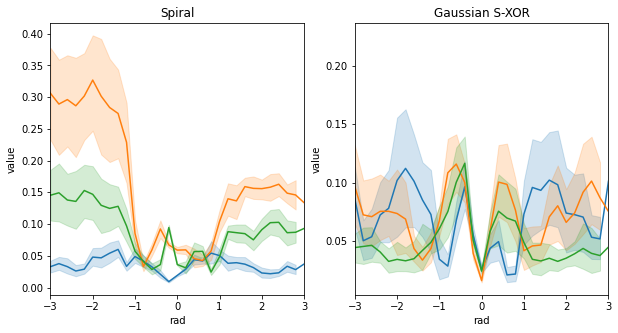

In [16]:
fig, ax = plt.subplots(1,2,figsize=[5*2,5])

for j in range(2):
    for i in range(3):
        tempdf = pd.DataFrame(lp_temp[j,:,i])
        tempdf.columns = x_range
        tempdf2 = tempdf.T
        tempdf2['rad'] = tempdf.T.index.to_numpy()
        tempdf2.columns = [f'{i}' for i in range(16)] + ['rad']
        tempdf3 = tempdf2

        tempdf3 = pd.melt(tempdf3, 'rad')

        sns.lineplot(data=tempdf3, x='rad', y='value', ci=95, ax=ax[j])

        ax[j].set_title(dtype[j])
        ax[j].set_xlim([-3,3])

### table after melting

In [17]:
tempdf3.head()

,rad,variable,value
0,-4.0,0,NaN
1,-3.8,0,NaN
2,-3.6,0,NaN
3,-3.4,0,NaN
4,-3.2,0,0.051877
